In [10]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from tqdm import tqdm
import os
import argparse
import json
import matplotlib.pyplot as plt
import numpy as np

from generator import Generator
from discriminator import Discriminator
from dataset import SatelliteDataset
from utils import save_example
import config

In [11]:
device = "cpu"

In [12]:
ds = SatelliteDataset("../../data/train")
batch_size = 2
loader = DataLoader(ds, batch_size)

In [13]:
rgb_a, rgb_ab, lc_a, lc_b, binary_mask, lc_ab, masked_areas = next(iter(loader))
rgb_a, rgb_ab, lc_a, lc_b, binary_mask = rgb_a.to(device), rgb_ab.to(device), lc_a.to(device), lc_b.to(device), binary_mask.to(device)
lc_ab = lc_ab.to(device)

In [15]:

rgb_a_unchanged_area = rgb_a.clone()

# look individually at changed area and do a pixel loss
# Not sure what type of loss is best,
# Maybe using some kind of local discriminator would be better, like in local and global inpainting paper
for j in range(len(masked_areas[0][0])):
    for i in range(len(masked_areas)):

        r_w = masked_areas[i][0][j]
        r_h = masked_areas[i][1][j]
        mask_size_w = masked_areas[i][2][j]
        mask_size_h = masked_areas[i][3][j]

        #r_w, r_h, mask_size_w, mask_size_h = masked_area
        # maybe not use the rgb_a is the classes are the same.
      #  local_gen_area = fake_img[j,:,r_w-config.local_area_margin:r_w + mask_size_w+config.local_area_margin, r_h-config.local_area_margin:r_h+mask_size_h+config.local_area_margin]
        rgb_ab_local_area = rgb_ab[j,:,r_w-config.local_area_margin:r_w + mask_size_w+config.local_area_margin, r_h-config.local_area_margin:r_h+mask_size_h+config.local_area_margin]


     #   fake_img_unchanged_area[j, :, r_w:r_w + mask_size_w, r_h:r_h + mask_size_h] = torch.zeros(3, mask_size_w, mask_size_h)
        rgb_a_unchanged_area[j, :, r_w:r_w + mask_size_w, r_h:r_h + mask_size_h] = torch.zeros(3, mask_size_w, mask_size_h)


In [33]:
torch.gather(rgb_ab, 1, index)

RuntimeError: Index tensor must have the same number of dimensions as input tensor

In [34]:
index.shape

torch.Size([8, 4, 2])

In [35]:
rgb_ab.shape

torch.Size([2, 3, 256, 256])

In [32]:
index = torch.stack(m_a)

In [28]:
m_a = [torch.vstack(ma) for ma in masked_areas]

In [26]:
torch.vstack(masked_areas[0])

tensor([[ 78, 165],
        [129, 172],
        [ 34,  53],
        [ 44,  48]])

In [23]:
masked_areas[0]

[tensor([ 78, 165]), tensor([129, 172]), tensor([34, 53]), tensor([44, 48])]

In [7]:
img = np.array(rgb_a_unchanged_area.cpu())[0]
img = np.moveaxis(img, 0, -1)

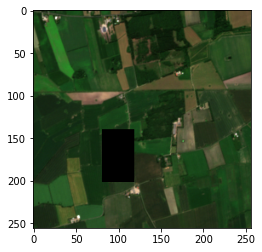

In [8]:
plt.imshow(img)

In [9]:
pixel_loss_fn = nn.MSELoss()

In [10]:
pixel_loss_fn(rgb_a_unchanged_area,rgb_a)

tensor(0.0005)

In [14]:
class StyleLoss(nn.Module):
    
    def __init__(self):
        super(StyleLoss, self).__init__()
        vgg_model = torch.hub.load('pytorch/vision:v0.9.0', 'vgg16', pretrained=True).to(device)
        self.relu3_3 = torch.nn.Sequential(*vgg_model.features[:16])
        
    def forward(self, img1, img2):
        phi1 = relu3_3(img1)
        phi2 = relu3_3(img2)

        batch_size, c, h, w = phi1.shape
        psi1 = phi1.reshape((batch_size, c, w*h))
        psi2 = phi2.reshape((batch_size, c, w*h))

        gram1 = torch.matmul(psi1, torch.transpose(psi1, 1, 2)) / (c*h*w)
        gram2 = torch.matmul(psi2, torch.transpose(psi2, 1, 2)) / (c*h*w)
        # as described in johnson et al.
        return torch.sum(torch.norm(gram1 - gram2, p = "fro", dim=(1,2))) / batch_size

In [20]:
def style_loss_fn2(phi1, phi2):
    phi1 = relu3_3(phi1)
    phi2 = relu3_3(phi2)
    
    batch_size, c, h, w = phi1.shape
    psi1 = phi1.reshape((batch_size, c, w*h))
    psi2 = phi2.reshape((batch_size, c, w*h))
    
    gram1 = torch.matmul(psi1, torch.transpose(psi1, 1, 2)) / (c*h*w)
    gram2 = torch.matmul(psi2, torch.transpose(psi2, 1, 2)) / (c*h*w)
    # as described in johnson et al.
    print(gram1.shape)
    return torch.sum(torch.norm(gram1 - gram2, p = "fro", dim=(1,2))) / batch_size


In [16]:
vgg_model = torch.hub.load('pytorch/vision:v0.9.0', 'vgg16', pretrained=True).to(device)
relu3_3 = torch.nn.Sequential(*vgg_model.features[:16])


Using cache found in C:\Users\hugih/.cache\torch\hub\pytorch_vision_v0.9.0


In [17]:
style_loss_fn = StyleLoss()

Using cache found in C:\Users\hugih/.cache\torch\hub\pytorch_vision_v0.9.0


In [18]:
style_loss_fn(rgb_a,rgb_a_unchanged_area)

tensor(0.0192, grad_fn=<DivBackward0>)

In [21]:
style_loss_fn2(rgb_a,rgb_a_unchanged_area)

torch.Size([2, 256, 256])


tensor(0.0192, grad_fn=<DivBackward0>)